# Why MaxPooling Beats AvgPooling.

MaxPooling empirically outperforms AvgPooling in most convolutional networks.

There have been many attempts to explain this, none entirely successful. 

Most explanations have focused on the feed-forward features of pooling:

1. MaxPooling clearly provides invariance to local translation, but this is also true of AvgPooling.
1. MaxPooling also provides non-linearity, which may improve specific networks.

This notebook attempts to illustrate an overlooked feature of MaxPooling: its ability to influence an earlier layer during training to cause that earlier layer to extract "better" features.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

### The Challenge.

1. Create 12 5x5 1-pixel deep stamps.
2. Repeated stamp a 256x256 by 1-pixel canvas with them.
3. From a 250x250x7x7x1 convolution of the canvas, learn strong (and ideally interpretable) feature detectors for the original 12 stamps.

In [2]:
stampSize = 5

def makeStamps():
    stamps = []
    sz = stampSize
    
    def g(f):
        m = sz//2
        z = np.zeros((sz, sz))
        for r in range(sz):
            for c in range(sz):
                z[r,c] = f(r-m,c-m)
        stamps.append(z)

    g(lambda r,c: not r or not c)
    g(lambda r,c: r==c or r+c==0)
    g(lambda r,c: (r+c)%2==0 and ((r+c)%4>0 or (r-c)%4>0))
    g(lambda r,c: (abs(r)>1 or abs(c)>1) and (r+c)%2)
    g(lambda r,c: (r+c)%4==0 and (r!=0 or c!=0))
    g(lambda r,c: r%2==0 and c%2==0)
    g(lambda r,c: r==2 or c==2)
    g(lambda r,c: r==-2 or c==-2)
    g(lambda r,c: r==-2 or c==2)
    g(lambda r,c: r==2 or c==-2)
    g(lambda r,c: r>-1 and r<=1 and c>-1 and c<=1)
    g(lambda r,c: (abs(r)==1 and abs(c)<2) or (abs(r)<2 and abs(c)==1))
    return stamps

stamps = makeStamps()

In [3]:
imageSize = 256

def makeImage():
    sz = imageSize + stampSize*2
    im = np.zeros((sz,sz))
    for i in range(5000):
        e = stamps[np.random.randint(0, len(stamps))]
        r = np.random.randint(0, sz-stampSize)
        c = np.random.randint(0, sz-stampSize)
        im[r:r+stampSize, c:c+stampSize] += e

    im = im[stampSize:-stampSize, stampSize:-stampSize]
    im = (im > 0) * 1.
    return im

### The Raw Data.

Although only a few kilobytes in size, the input image is so cluttered that even a human may find it challenging to extract the underlying stamps/features...

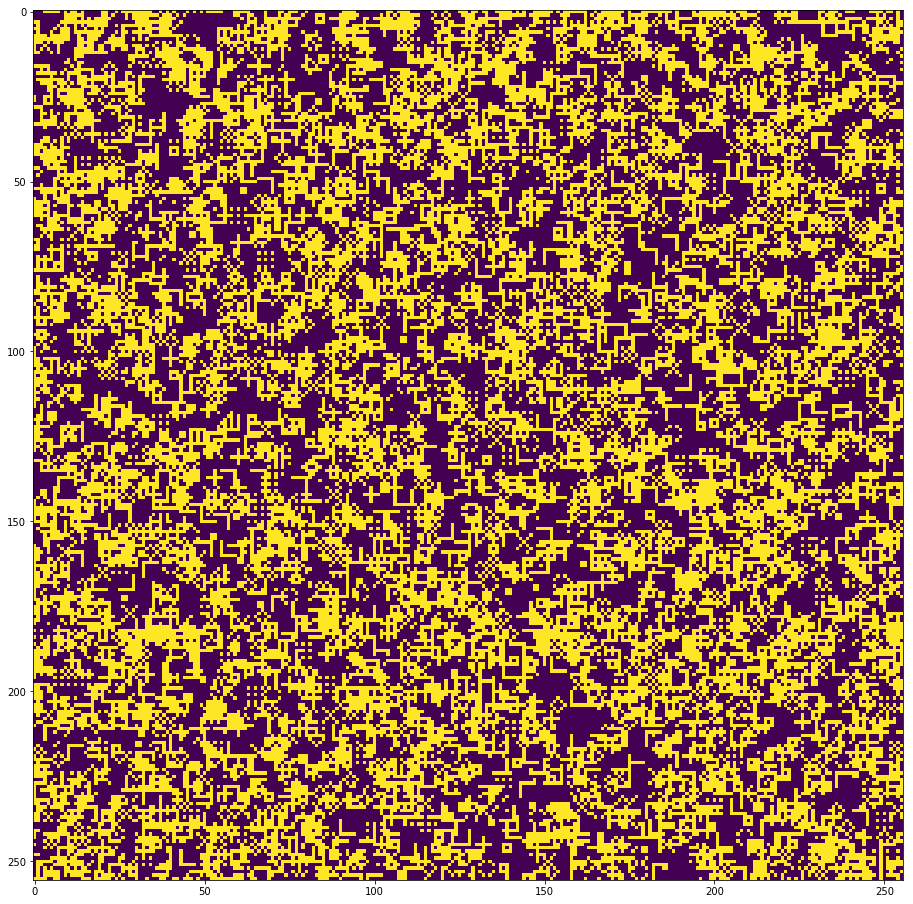

In [4]:
im = makeImage()
plt.figure(figsize=(16,16))
plt.imshow(im)  
plt.show()

### The DataSet.

Our dataset will simply be all 7x7 patches of the 256x256 image, valid padding, yielding 62.5K 49-bit vectors.

In [5]:
def conv(im, sz, trim=True):
    p = []
    s2 = sz//2
    for r in range(sz):
        for c in range(sz):
            i = np.roll(np.roll(im, s2-r, axis=0), s2-c, axis=1)
            p.append(i)
    r = np.array(p)
    if trim:
        r = r[:, s2:-s2, s2:-s2]
    r = np.moveaxis(r, 0, 2)
    return r

In [6]:
def pad(inp, n):
    if n == 0:
        return inp
    im = np.zeros((inp.shape[0]+n, inp.shape[1]+n))
    s = n//2
    e = n - s
    im[s:-e,s:-e] = inp
    return im

def mkIm(ims, border=2):
    elems = np.array([ pad(im, 4) for im in ims ] )
    
    r = len(elems)
    c = 1
    while r>c:
        r = r//2
        c = c*2
        
    y,x = elems[0].shape
    ret = elems.reshape(r,c,y,x).transpose(0,2,1,3)
    ret = ret.reshape(r*y,-1)
    return ret

def show(ims):
    plt.figure(figsize=(10,10))
    nr = int(len(ims)**.5)
    nc = (len(ims) + nr - 1) // nr
    for i, im in enumerate(ims):
        plt.subplot(nr, nc, i+1)
        plt.imshow(im)
        plt.axis('off')
    plt.show()


#### Sanity Check.

Just checking the top left corner of our input image matches the dataset...

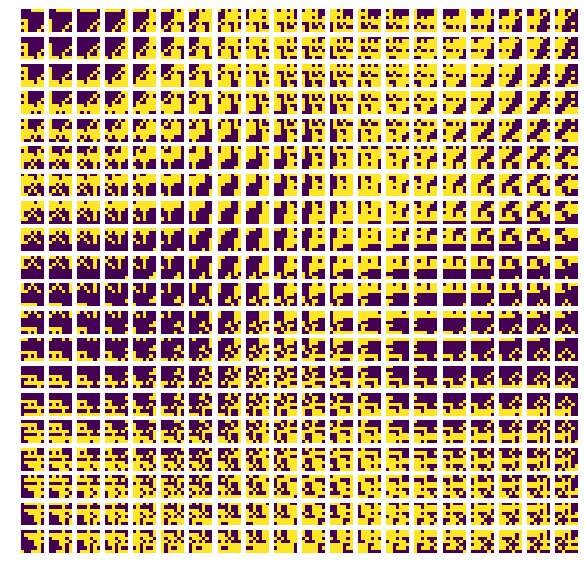

In [7]:
featureSize = 7
dataset = conv(im, featureSize)
show(dataset[:20,:20].reshape(-1, featureSize, featureSize))

### The Baseline Learning Layer.

K-Means on the 7x7 patches provides a fast, simple, robust, and interpretable trainable layer.

It requires minimal assumptions, is unsupervised, is biologically plausible, and its feed-forward implementation can be expressed as a dot-product + bias + a softmax layer.

We use 100 centroids (clusters) in the naive hope that some will respond strongly to the underlying features/stamps.

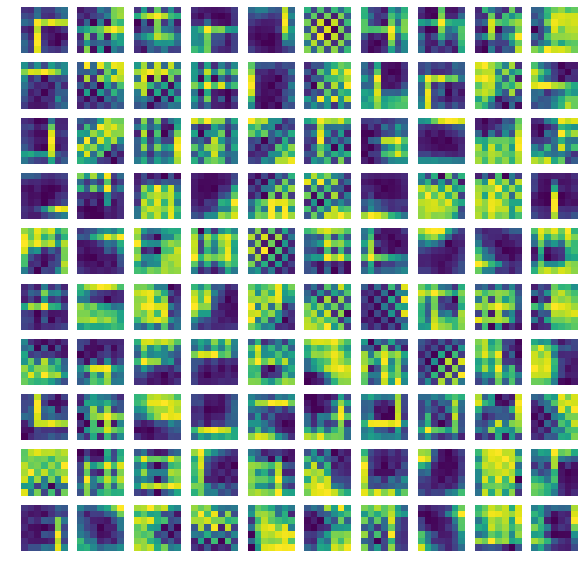

In [8]:
k = 100

from scipy.cluster.vq import kmeans2

d = dataset.reshape(-1, featureSize**2)
km, _ = kmeans2(d, k, minit='points')
show(km.reshape(-1, featureSize, featureSize))

In [9]:
def stampToFeatures(stamp):
    feature = pad(stamp, featureSize-stampSize)

    numShifts = 5
    im = pad(feature, numShifts-1)
    tgts = conv(im, featureSize, trim=True)
    
    tgts = tgts.reshape(-1, featureSize * featureSize)
    return tgts

def dist2(feature, tgts):
    e = [ np.sum((t-feature)**2) for t in tgts ]
    return min(e)
        
def bestFeatures(stamp, features):
    tgts = stampToFeatures(stamp)
    mm = [ dist2(f, tgts) for f in features ]
    e = sorted( [ (m, i, f) for i,(m,f) in enumerate(zip(mm, features)) ] ) # use index as tie-breaker
    els = [ x[2] for x in e ]
    return np.array(els)

def show_detectors(z):
    assert len(stamps) == 12
    plt.figure(figsize=(20,10))
  
    for i, stamp in enumerate(stamps):
        els = bestFeatures(stamp, z)
        
        i1 = pad(stamp, 4)
        ee = els[:12].reshape(-1, featureSize, featureSize)
        i2 = mkIm(ee)
    
        plt.subplot(4, 6, i*2+1)
        plt.imshow(i1)
        plt.axis('off')
        
        plt.subplot(4, 6, i*2+2)
        plt.imshow(i2)
        plt.axis('off')
        
    
    plt.show()
    

#### The Most Responsive Feature Detectors by Stamp.

For each stamp, we display the 12 feature detectors that respond most strongly. 

The baseline results are not stunning...

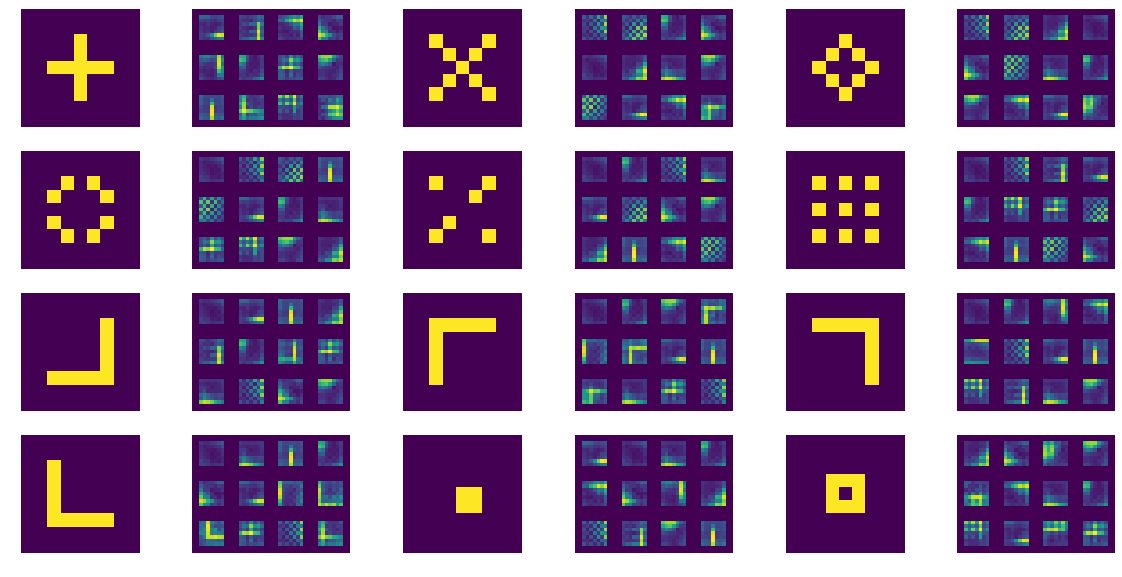

In [10]:
show_detectors(km)

## A MaxPool Version of K-Means.

To apply the local winner-take-all behavior of MaxPooling on K-Means, we:

1. Initialize the dataset to the 7x7 convolved patches.
2. Fit K-Means, finding the distance to the closest centroid for each patch.
3. For each dataset patch, replace it with the best patch in its local max-poolling area.
4. Repeat.

/Users/mmn/anaconda3/lib/python3.6/site-packages/scipy/cluster/vq.py:525: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


10


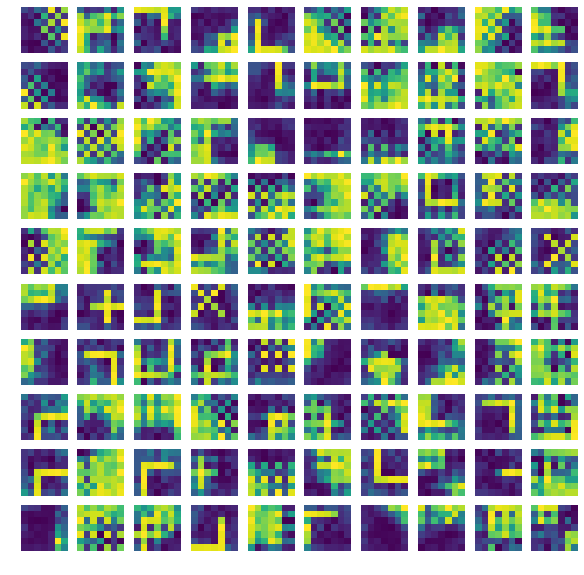

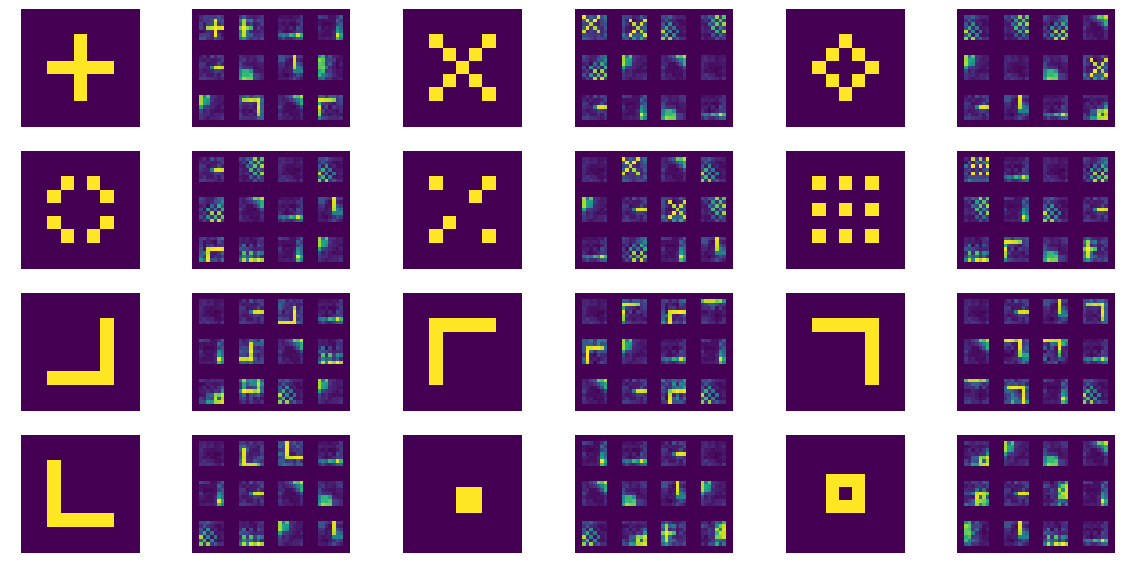

50


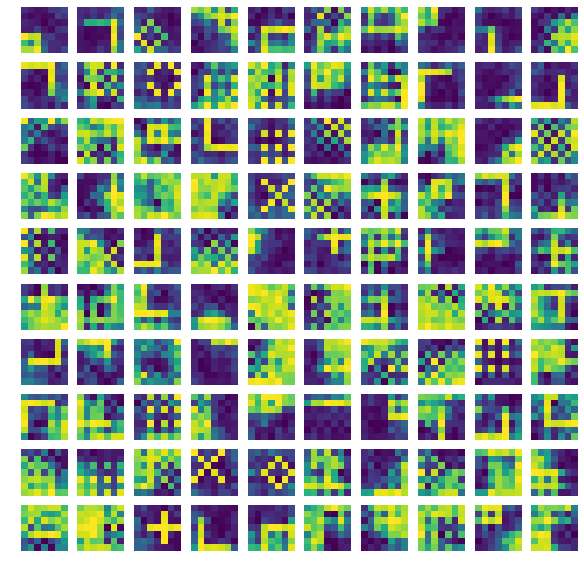

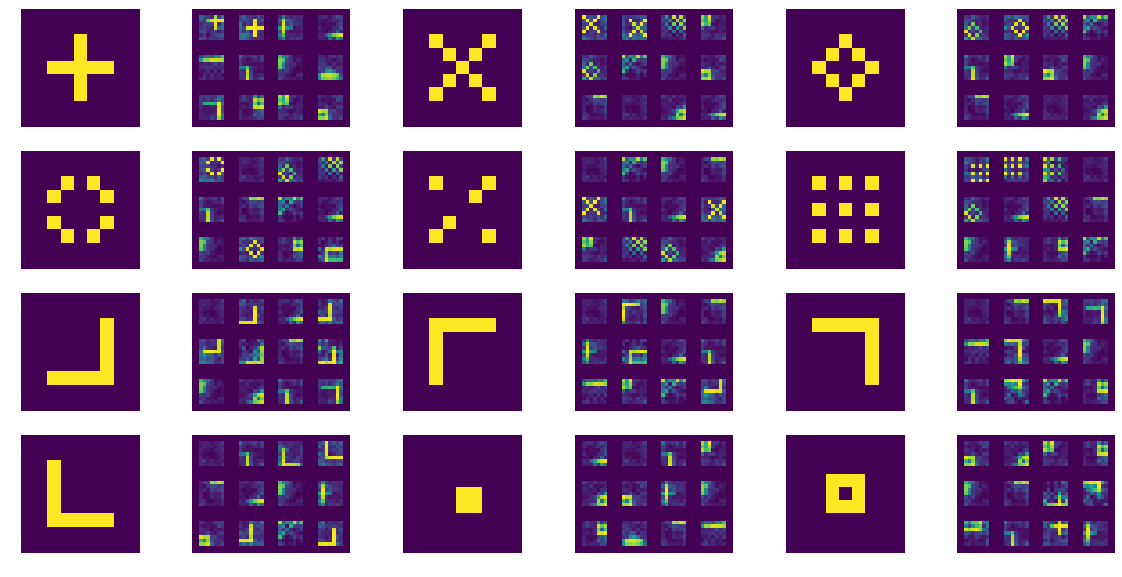

100


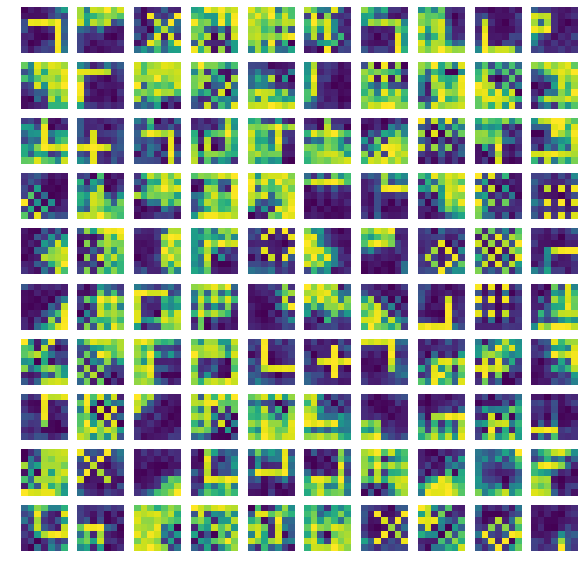

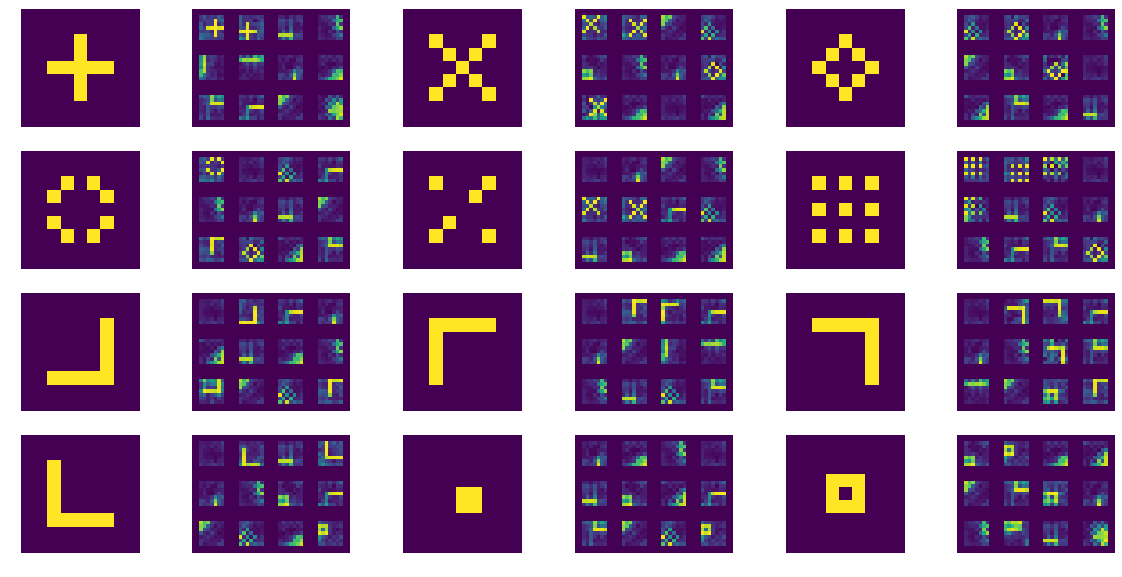

200


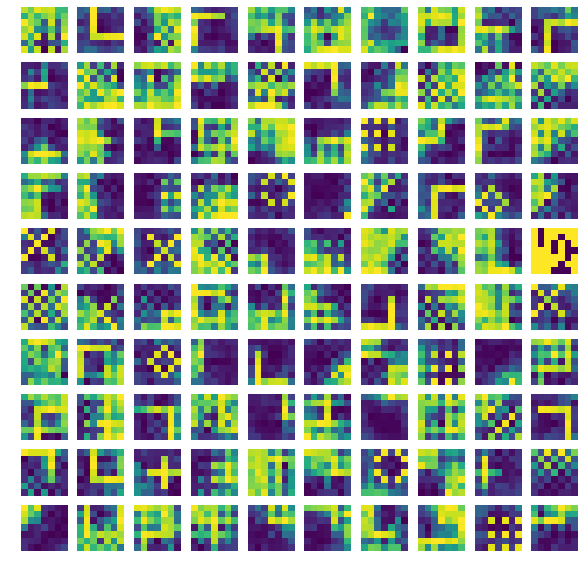

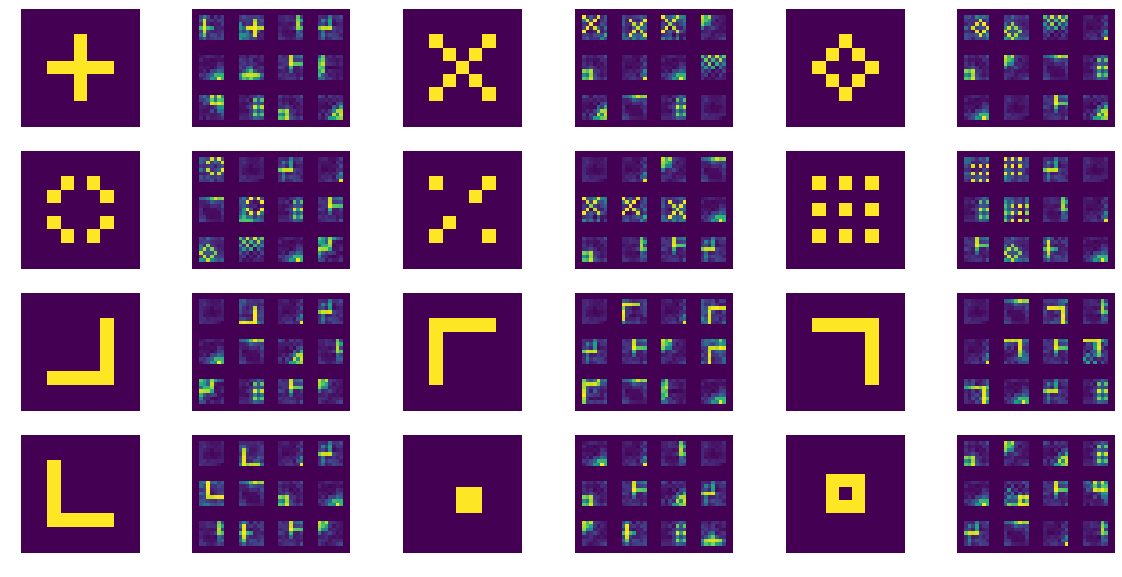

400


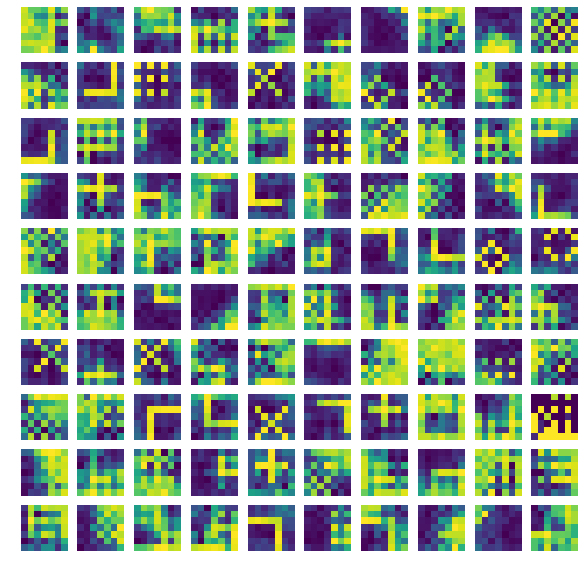

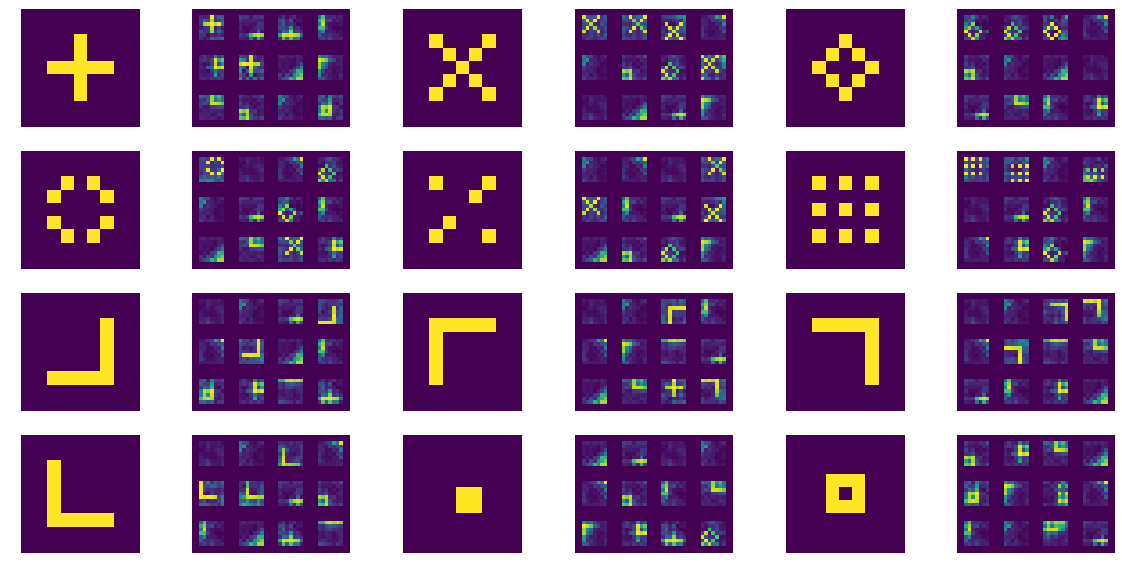

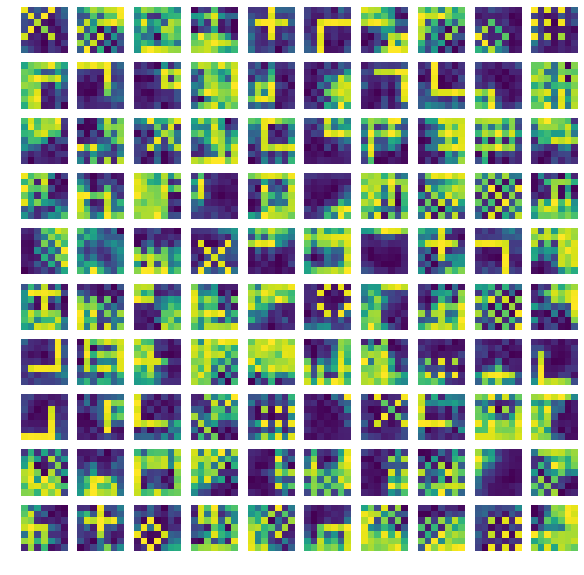

In [11]:
class MP_KM(object):
    
    def __init__(self, numCl, im, featureSize, poolSize=None):
        self.convs = conv(im, featureSize)
        self.setDataset(self.convs)
        
        self.numCl = numCl
        self.featureSize = featureSize
        self.poolSize = poolSize if poolSize else featureSize - 3
        
    def setDataset(self, x):
        self.dataset = x.reshape(-1, featureSize * featureSize)
        
    def clusters(self):
        z, _ = kmeans2(self.dataset, self.numCl, minit='points')
        return z
    
    def train(self, verboseIters=[], nIter=100):
        for i in range(nIter):
            verbose = i+1 in verboseIters
            if verbose:
                print(i+1)
            self._train1(verbose)

    def negD2(self, z, x):
        p2 = np.sum(z*z, axis=1)
        x2 = np.sum(x*x, axis=2)
        x2 = x2.reshape(x2.shape+(1,))
        d2 = 2 * np.dot(x, z.T) - p2 - x2       # neg dist squared of source convolutions
        n2 = np.max(d2, axis=2, keepdims=True)  # -dist2 to nearest centroid
        return n2
    
    def _train1(self, verbose):
        cl = self.clusters()

        if verbose:
            show(cl.reshape(-1, self.featureSize, self.featureSize))
            show_detectors(cl)
            
        convs = self.convs
        
        n2 = self.negD2(cl, convs)
        
        c2 = conv(n2, self.poolSize) # local area best nearest distances
        x2 = conv(convs, self.poolSize) # source convolutions in local area
        
        am = np.argmax(c2, axis=2)[:,:,0] # index of best match in local area
        
        sz0 = x2.shape[0]
        sz1 = x2.shape[1]
        
        # create new synthetic dataset where each source convolution contributes the
        # best source convolution within its local area

        i = np.array(range(sz0))
        j = np.array(range(sz1))
        d3 = x2[ i[:, np.newaxis], j, am]
        
        if 0: # show ds size
            nn = np.arange(convs.shape[0] * convs.shape[1])
            nn = nn.reshape(convs.shape[0], convs.shape[1], 1)
            nn = conv(nn, self.poolSize).astype(int)
            nn = nn[ i[:, np.newaxis], j, am]
            l = []
            for i in range(nn.shape[0]):
                for j in range(nn.shape[1]):
                    l.append(nn[i,j,0])
            print(len(l), len(set(l)))
        
        self.setDataset(d3)

        
v = [10, 50, 100, 200, 400]
            
mk = MP_KM(k, im, featureSize, poolSize=None)
mk.train(verboseIters=v, nIter=v[-1]+1)
mpkm = mk.clusters()

show(mpkm.reshape(-1, featureSize, featureSize))

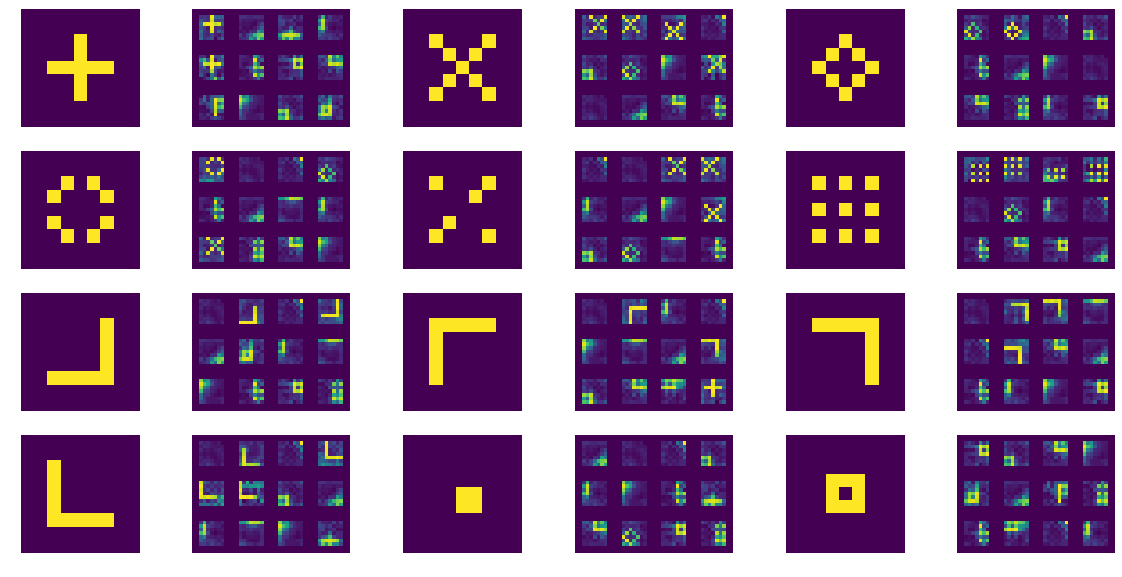

In [12]:
show_detectors(mpkm)